In [1]:
import requests
import warnings
import math

import pandas as pd
import datetime as dt

import plotly.express as px

from tqdm import tqdm
from gql import gql, Client # to use GraphQL
from gql.transport.requests import RequestsHTTPTransport
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

%matplotlib inline

warnings.filterwarnings('ignore')

# Uniswap V3 position with hedge

The document contains calculations for the liquidity, tokens amounts and fees. The formulae may be found in the paper [paper](https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf) by Atis Elsts and in the original [whitepaper](https://uniswap.org/whitepaper-v3.pdf) for Uniswap V3. 

## Load Uniswap V3 pool data using TheGraph

In [2]:
# connect to the Uniswap V3 Subgraph
uni_transport = RequestsHTTPTransport(
    url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3', #here we can use uniswap-v3
    verify = True,
    retries=3,  
)
client = Client(transport = uni_transport)

In [3]:
data_pools = []

In [4]:
# get the set of pools available in the Uniswap V3 Subgraph
# the examples for Uniswap are available in the Uniswap documentation: https://docs.uniswap.org/api/subgraph/guides/examples
# GraphQL tutorials: https://thegraph.com/docs/en/querying/querying-best-practices/

query = gql(
    """
query ($first: Int!, $skip: Int!) { 
  pools (first: $first, skip: $skip){
    id
    volumeUSD
    token0{
        name
    }
    token1{
        name
    }
  }
}
"""
)

page_size = 1000
skip = 0

while True:
    if skip > 5000:
        break 
    vars = {"first": page_size, "skip": skip}
    result = client.execute(query, variable_values=vars)
    
    data = []
    for i in result['pools']:
        data.append([
            i['id'],
            i['volumeUSD'],
            i['token0']['name'],
            i['token1']['name']
        ])
        
    df = pd.DataFrame(data)
    df.columns = ['id','volumeUSD','name0','name1']
    df['Pair'] = df['name0'] + '-' + df['name1']
    df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])     
        
    data_pools.extend(df.to_dict('records'))
    skip += page_size
    
    if not result['pools']:
        break


data_pools = pd.DataFrame(data_pools)

In [5]:
# select the largest pools with at least $1B in trading volume

data_pools = data_pools.reset_index()
data_pools['volumeUSD'] = data_pools['volumeUSD'].astype('int64')
large_pools = data_pools[ data_pools['volumeUSD'] > 1_000_000_000]

## Liquidity provision in Uniswap V3

USDC - WETH pool: 0x11b815efb8f581194ae79006d24e0d814b7697f6

0x11b815efB8f581194ae79006d24E0d814B7697F6

In [6]:
data_pool = []

# query for the USDC-WETH pool
query = gql(
    """
    {
        poolDayDatas(
            first: 1000
            orderDirection: desc
            where: {pool: "0x11b815efb8f581194ae79006d24e0d814b7697f6"}
        ) {
            date
            token0Price
            token1Price
            feesUSD
            liquidity
            volumeUSD
        }
    }
    """
)


result = client.execute(query, variable_values=vars)

data = []
for i in result['poolDayDatas']:
    data.append([
        i['date'],
        i['token0Price'],
        i['token1Price'],
        i['feesUSD'],
        i['liquidity'],
        i['volumeUSD']
    ])


df = pd.DataFrame(data)
df.columns = ['date', 'token1Price','token0Price', 'feesUSD', 'liquidity', 'volumeUSD']

df['token0Price'] = pd.to_numeric(df['token0Price'])
df['token1Price'] = pd.to_numeric(df['token1Price'])
df['feesUSD'] = pd.to_numeric(df['feesUSD'])
df['USDC/WETH'] = pd.to_numeric(df['token0Price']/df['token1Price'])
df['datetime'] = pd.to_datetime(df['date']*1000000000)
df['liquidity'] =  df['liquidity'].astype(float)
df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])

# df

In [7]:
data_pool = df.copy()

In [8]:
data_pool['datetime'] = data_pool['datetime'].dt.date
data_pool = data_pool[['token0Price', 'token1Price', 'feesUSD', 'liquidity', 'datetime', 'volumeUSD']]
# data_pool

To construct the pseudo delta neutral strategy we need to use perps. We'll take the data on ETH perps from the Binance API

In [9]:
# funding rates for ETH

url = 'https://fapi.binance.com/fapi/v1/fundingRate'
symbol = 'ETHUSDT'

start_time = dt.datetime(2021, 5, 5).timestamp() * 1000
end_time = dt.datetime(2023, 10, 26).timestamp() * 1000

data = requests.get(url, params={'symbol': symbol, 'startTime': int(start_time)}).json()
last_time = data[-1]['fundingTime']


while last_time <= end_time:
    data.extend(requests.get(url, params={'symbol': symbol, 'startTime': int(last_time)}).json())
    last_time = data[-1]['fundingTime']

df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['fundingTime'], unit='ms')
df['fundingRate'] = pd.to_numeric(df['fundingRate'])
df = df.drop_duplicates()

In [10]:
data_funding = df.copy()

In [11]:
data_funding['datetime'] = data_funding['datetime'].dt.date
data_funding = data_funding.groupby('datetime').sum()
data_funding = data_funding.reset_index()
data_funding = data_funding[['datetime', 'fundingRate']]

In [12]:
all_data = pd.merge(data_pool, data_funding, how="left", on='datetime')
all_data['volume24H'] = all_data['volumeUSD'].rolling(window=7).mean()
for i in range(8):
    all_data['volume24H'][i] = data_pool['volumeUSD'][i]
# all_data
#print(data_pool)

window_size = 30  # Размер окна для вычисления среднего
all_data['volatility'] = all_data['token0Price'].rolling(window=window_size).std()
for i in range(window_size-1):
    all_data['volatility'][i] = all_data['volatility'][window_size-1]
#all_data['volatility'] = all_data["token0Price"].std()
# print(all_data)
# print(all_data['volatility'][6])

# px.line(all_data, x='datetime', y='liquidity')


#abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std()

# Startegy Backtest

Liquidity provision strategy: put capital into the Uniswap V3 pool and use perps to hedge the position. 

In [13]:
class UniswapV3Position:

    def __init__(self, token0_amount: float, token1_amount: float, liquidity: float,
                 price_current: float, price_upper: float, price_lower: float):
        self._token0_amount: float = token0_amount
        self._token1_amount: float = token1_amount
        self._liquidity: float = liquidity
        self._price_current: float = price_current
        self._price_init: float = price_current
        self._price_upper: float = price_upper
        self._price_lower: float = price_lower
        self._acc_fees: float = 0

    def update_state(self, price: float) -> None:
        if price < self._price_lower:
            self._token0_amount = 0
            self._token1_amount = self._liquidity * (1/(self._price_lower**0.5) - 1/(self._price_upper**0.5))
        elif self._price_lower <= price < self._price_upper:
            self._token0_amount = self._liquidity * (price**0.5 - self._price_lower**0.5)
            self._token1_amount = self._liquidity * (1/(price**0.5) - 1/(self._price_upper**0.5))
        else:
            self._token0_amount = self._liquidity * (self._price_upper**0.5 - self._price_lower**0.5)
            self._token1_amount = 0
        self._price_current = price

    def balance(self, side: bool = True) -> float:
        if side:
            return self._token0_amount + self._token1_amount * self._price_current + self._acc_fees
        return self._token0_amount / self._price_current + self._token1_amount + self._acc_fees / self._price_current 

    @classmethod
    def price_to_tick(cls, price: float) -> float:
        return math.floor(math.log(price, 1.0001))

    @classmethod
    def tick_to_price(clas, tick: float) -> float:
        return 1.0001 ** tick
    
    def __str__(self) -> str:
        return f"token0: {self._token0_amount}, token1: {self._token1_amount}, liquidity: {self._liquidity}, price_current: {self._price_current}, price_upper: {self._price_upper}, price_lower: {self._price_lower}"
    
    def __repr__(self) -> str:
        return self.__str__()


def create_position_by_notional(
            deposit_amount_in_notional: float,
            price_current: float, price_upper: float, price_lower: float,
    ) -> UniswapV3Position:
        X = deposit_amount_in_notional

        liquidity = (X/2/price_current) / (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        ratio = token0_amount / (X/2/price_current)
        new_deposit_amount = X/(ratio + price_current)

        token1_amount = new_deposit_amount
        liquidity = new_deposit_amount /  (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        return UniswapV3Position(token0_amount, token1_amount, liquidity, price_current, price_upper, price_lower)

In [14]:
class HedgePosition: 
    def __init__(self, size: float, entry_price: float): 
        self._size: float = size 
        self._entry_price: float = entry_price 
        self._current_price: float = entry_price 
 
    def update_state(self, price: float) -> None: 
        self._current_price = price 
 
    def pnl(self) -> float: 
        return self._size * (self._current_price - self._entry_price) 
 
    def __str__(self) -> str: 
        return f'BaseHedgePosition(size={self._size}, entry_price={self._entry_price}, current_price={self._current_price})' 
 
 
class Hedge: 
    def __init__(self): 
        self._position: HedgePosition = None 
        self._balance: float = 0 
        self._current_price: float = None 
        self._trading_fee: float = 0.0003 # 0.03% комиссия взята с официального сайта 
 
    def deposit(self, amount: float): 
        if amount <= 0: 
            raise Exception(f'Cannot deposit non-positive amount {amount}') 
        self._balance += amount 
 
    def withdraw(self, amount: float): 
        if amount > self._balance: 
            raise Exception(f'Not enough balance to withdraw {amount}, available {self._balance}') 
        self._balance -= amount 
 
    @property 
    def balance(self) -> float: 
        return self._balance 
 
    @property 
    def position(self) -> HedgePosition: 
        return self._position 
 
    def margin_balance(self) -> float: 
        if not self._position: 
            return self._balance 
        return self._balance + self._position.pnl() 
 
    def update_state(self, price: float, funding: float) -> None: 
        self._current_price = price 
        if self._position: 
            self._position.update_state(price) 
            self._balance += funding * abs(self._position._size) * self._current_price 
        self.__check_liquidation() 
 
    def open_position(self, size: float, entry_price: float) -> None: 
        if self._position: 
            raise Exception(f'Cannot open position, already have one {self._position}') 
 
        if size > 0: 
            raise Exception(f'Cannot open short position {size}') 
 
        self._position = HedgePosition(size, entry_price) 
        self._balance -= abs(size) * entry_price * self._trading_fee 
 
    def close_position(self) -> None: 
        if not self._position: 
            return 
        self._balance -= abs(self._position._size) * self._current_price * self._trading_fee 
        self._balance += self._position.pnl() 
        self._position = None 
 
    def __check_liquidation(self): 
        if self._position: 
            # liquidate if margin balance is 5% of the position size 
            if self.margin_balance() < abs(self._position._size) * 0.05: 
                self._balance = 0 
                self._position = None

Ниже можно увидеть, как выглядила изначальная стратегия на нашем семинаре: у нас есть пул и хедж, задается некоторый начальный рендж для пула и затем ребалансировки происходили только в момент, когда цена выходит за пределы ренджа. В качестве пула я взял второй по объему из всех существующих сейчас пулов, выбрал его, так как в отличии от самого первого пула скорее всего во втором будем меньше алгоритмической торговли, поэтому эффект "рыночного эмпакта", скорее всего будет не таким сильным, а значит смоделированные на бумаге стратегии будут релевантнее на реальном рынке, а значит их результаты интереснее для изучения. Пояснения: в самом большом пуле много алгоритмической торговли в силу высокой ликвидности (в обычном смысле), а во-втором поменьше, а значит вероятность, что будет существовать бот, который будет "кушать" нашу стратегию намного ниже, однако преймущества большого объемного пула сохраняются.

Я буду брать ее за основу и последовательно изменять сомнительные куски, так, я планирую добавить\изменить:

- $\Delta$ - хеджирование. Дело в том, что в нашей изначальной стратегии бралась некоторая фиксированная H, что мне очевидно нерелевантно в условиях рынка с меняющимися волатильностями, трендами и т.п.
    -При невалидных значениях в подкоренном выражении попытаться подобрать значение H. В формуле есть используются функции, которую уменьшают ОДЗ, поэтому могут появлять невалидные значения, не позволяющие оценить H, значит требуется в таких случаях как-то выбирать H
  
- Ребалансировка хеджирования чаще, чем раз в изменение рэнжа. Очевидно, если очень это не делать, то при росте рынка наше хеджирование превращается в шорт, что очень сильно бьёт по нашим накомплениям.

- Изменение оценки стандартного отклонения. В изначальном коде уж очень странно она сделана и в первых и последних числах наших исторических данных может давать нерелевантные значения.


Хочу заметить, что затем все эти позиции я буду оптимизировать через перебор всех вариантов, таким образом чтобы "изначальный вариант" также учитывался, поэтому можно будет увидеть оптимизацию.  енияниянe}

Income: 0.7325080422688711


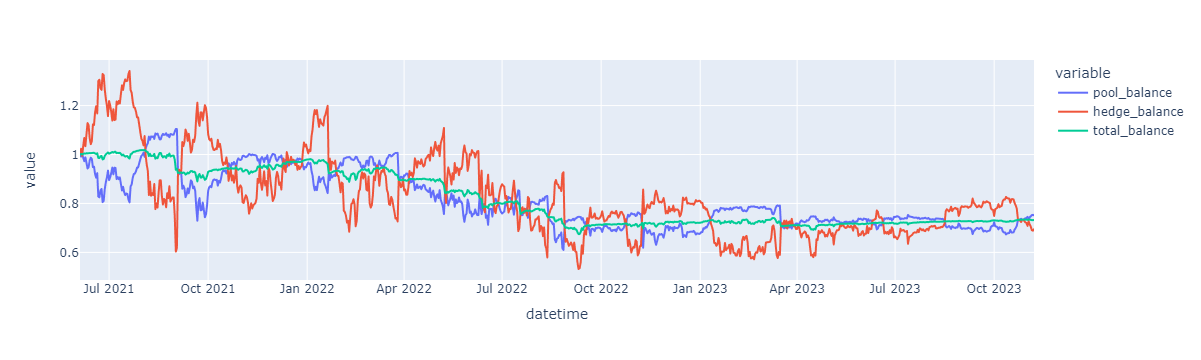

In [15]:
class Strategy:
    def __init__(self, 
                 states: pd.DataFrame,STD_COUNT,STD_TIMERANGE
                ):
        self.params: dict = {
            'STD_COUNT': STD_COUNT,
            'START_EQUITY': 100_000,      
            'STD_TIMERANGE': STD_TIMERANGE, # days
        }
        self._hedge: Hedge = Hedge()
        self._pool_position: UniswapV3Position = None
        self._states: pd.DataFrame = states
        self._data = []

    def update_fee(self, price: float, i: dict):  
    #10**(-18)*math.ceil(10**18 * 
        FeesTees = 0.0005
        liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
        liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
        
        if price < self._pool_position._price_lower:  
            deltaL = liquidityAmount0
        elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
            deltaL = min(liquidityAmount0, liquidityAmount1)  
        else:  
            deltaL = liquidityAmount1  
        self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))

    
    def calculate_std(self, timestamp: dt.datetime) -> float:
        return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std())

    def run(self):
        remember_price = None
        df_for_run = pd.DataFrame(self._states)
        for i, state in df_for_run.iterrows():
            if i < self.params['STD_TIMERANGE']:
            #print(f'Strategy | Skipping {state["datetime"]}')
                continue

            if not remember_price:
                remember_price = float(state['token0Price'])
        
            
            self._hedge.update_state(state['token0Price'], state['fundingRate'])
            if self._pool_position:
                self._pool_position.update_state(state['token0Price'])
                self.update_fee(self._pool_position._price_current, i)
                if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                    self.rebalance(state)
                    remember_price = None
            else:
                 self.rebalance(state)
                
            self._data.append([
                state['datetime'],
                state['token0Price'],
                self._pool_position.balance(),
                self._hedge.margin_balance(),
                self._pool_position.balance() + self._hedge.margin_balance(),
                self._pool_position._price_upper,
                self._pool_position._price_lower,
            ])

        return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])

    def rebalance(self, state):
        
    #print(f'Strategy | Start rebalancing at {state["datetime"]}')

        std = self.calculate_std(state['datetime'])
        #print(f'Strategy | Calculated std {std}')
        
        if self._pool_position is not None: 
            pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
            self._hedge.close_position()
            equity: float = pool_balance + self._hedge.margin_balance()
        else:
            equity: float = self.params['START_EQUITY']

        H=1/3


        
        # virtual witfhdraw and deposit for rebalancing capital
        self._hedge.withdraw(self._hedge.margin_balance())
        self._hedge.deposit(H * equity)

        self._pool_position = create_position_by_notional(
            (1-H)*equity,
            price_current=state['token0Price'],
            price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
            price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
        )
            
        self._hedge.open_position(
            size=-(self._pool_position.balance() / 2) / state['token0Price'],               
            entry_price=state['token0Price'],
        )
        # print(f'Strategy | Created pool position {self._pool_position}')
        # print(f'Strategy | New balances: pool {self._pool_position.balance()}, hedge {self._hedge.margin_balance()}, equity {self._pool_position.balance() + self._hedge.margin_balance()}')
        # print(f'Strategy | End rebalancing at {state["datetime"]}')



# you can take filtered data
# filtered_data = all_data[all_data['datetime'] > dt.datetime(2021, 5, 5).date()]
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30)
data = strategy.run()


df = pd.DataFrame(data)


# scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:",df['total_balance'].to_list()[-1])

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])


Первое, что я предлагаю это поменять хедж, так как ребалансировка у нас происходит только при выходе за границы хэджа, то в какой-то момент мы начинаем терять деньги из-за этого и следует делать ребалансировку раз в какой-то промежуток, в качестве "промежутка" будем брать колебания цены, так, если цена вышла за некоторый промежуток, то мы делаем ребаланс, я рассматриваю самую банальную модель, когда мы просто оцениваем $state['token0Price']*(1-{koef})<= remember_{price} <= (1+{koef}) * state['token0Price']$, однако также можно прикрутить волатильность и как-то менять этот промежуток. 

Проведём бектесты

koef: 0.4
Income: 0.7281448727658772


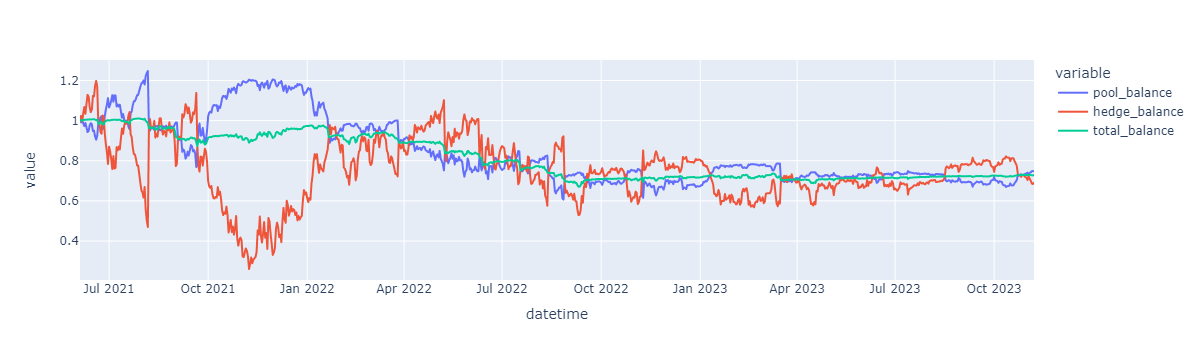

In [16]:
class Strategy:
            def __init__(self, 
                         states: pd.DataFrame,STD_COUNT,STD_TIMERANGE
                        ):
                self.params: dict = {
                    'STD_COUNT': STD_COUNT,
                    'START_EQUITY': 100_000,
                    'STD_TIMERANGE': STD_TIMERANGE, # days
                }
                self._hedge: Hedge = Hedge()
                self._pool_position: UniswapV3Position = None
                self._states: pd.DataFrame = states
                self._data = []
    
            def update_fee(self, price: float, i: dict):  
            #10**(-18)*math.ceil(10**18 * 
                FeesTees = 0.0005
                liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
                liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
            
                if price < self._pool_position._price_lower:  
                    deltaL = liquidityAmount0
                elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
                    deltaL = min(liquidityAmount0, liquidityAmount1)  
                else:  
                    deltaL = liquidityAmount1  
                self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))
    
        
            def calculate_std(self, timestamp: dt.datetime) -> float:
                return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std())
    
            def run(self):
                remember_price = None
                df_for_run = pd.DataFrame(self._states)
                for i, state in df_for_run.iterrows():
                    if i < self.params['STD_TIMERANGE']:
                    #print(f'Strategy | Skipping {state["datetime"]}')
                        continue
    
                    if not remember_price:
                        remember_price = float(state['token0Price'])
                
                
                    self._hedge.update_state(state['token0Price'], state['fundingRate'])
                    if self._pool_position:
                        self._pool_position.update_state(state['token0Price'])
                        self.update_fee(self._pool_position._price_current, i)
                        if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                            self.rebalance(state,True)
                            remember_price = None
                        if not remember_price:
                            remember_price = float(state['token0Price'])
                        if not (state['token0Price']*(1-koef)<= remember_price <= (1+koef) * state['token0Price']):
                            self.rebalance(state, False)
                            remember_price = None
                    else:
                        self.rebalance(state, True)
    
                    self._data.append([
                        state['datetime'],
                        state['token0Price'],
                        self._pool_position.balance(),
                        self._hedge.margin_balance(),
                        self._pool_position.balance() + self._hedge.margin_balance(),
                        self._pool_position._price_upper,
                        self._pool_position._price_lower,
                    ])
    
                return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])
    
            def rebalance(self, state, bool):
            
            #print(f'Strategy | Start rebalancing at {state["datetime"]}')
    
                std = self.calculate_std(state['datetime'])
            #print(f'Strategy | Calculated std {std}')
            
                if self._pool_position is not None: 
                    pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
                    self._hedge.close_position()
                    equity: float = pool_balance + self._hedge.margin_balance()
                else:
                    equity: float = self.params['START_EQUITY']
    
                def is_valid_number(number):
            # Проверка на не NaN
                    if np.isnan(number):
                        return False
                # Проверка на не равно 0 и больше нуля
                    if number > 0:
                        return True
                    return False
            
            #print("decim:",state['token0Price'] * (1 - std * self.params['STD_COUNT']))
    
    
                # if(is_valid_number(state['token0Price'] * (1 - std * self.params['STD_COUNT']))):
                #     r = math.sqrt((state['token0Price'] * (1 + std * self.params['STD_COUNT']))/(state['token0Price'] * (1 - std * self.params['STD_COUNT'])))
                #     H = (math.sqrt(r) - 1)/(r-1)
                # else: H = 0.00001
                H =1/3
    
            
            # virtual witfhdraw and deposit for rebalancing capital
                self._hedge.withdraw(self._hedge.margin_balance())
                self._hedge.deposit(H * equity)
    
                if(bool):
                    self._pool_position = create_position_by_notional(
                        (1-H)*equity,
                        price_current=state['token0Price'],
                        price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
                        price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
                    )
                else:
                    self._pool_position = create_position_by_notional(
                        (1-H)*equity,
                        price_current=state['token0Price'],
                        price_upper = self._pool_position._price_upper,
                        price_lower = self._pool_position._price_lower
                    )
    
                
                self._hedge.open_position(
                    size=-(self._pool_position.balance() / 2) / state['token0Price'],               
                    entry_price=state['token0Price'],
                )
            # print(f'Strategy | Created pool position {self._pool_position}')
            # print(f'Strategy | New balances: pool {self._pool_position.balance()}, hedge {self._hedge.margin_balance()}, equity {self._pool_position.balance() + self._hedge.margin_balance()}')
            # print(f'Strategy | End rebalancing at {state["datetime"]}')
    
    
    
        # you can take filtered data
        # filtered_data = all_data[all_data['datetime'] > dt.datetime(2021, 5, 5).date()]
koef = 0.4 #заметим, что на значениях 1 выгода больше
print("koef:",koef)
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30)
data = strategy.run()
    
    
df = pd.DataFrame(data)
    
    
        # scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:", df['total_balance'].to_list()[-1])
    
px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

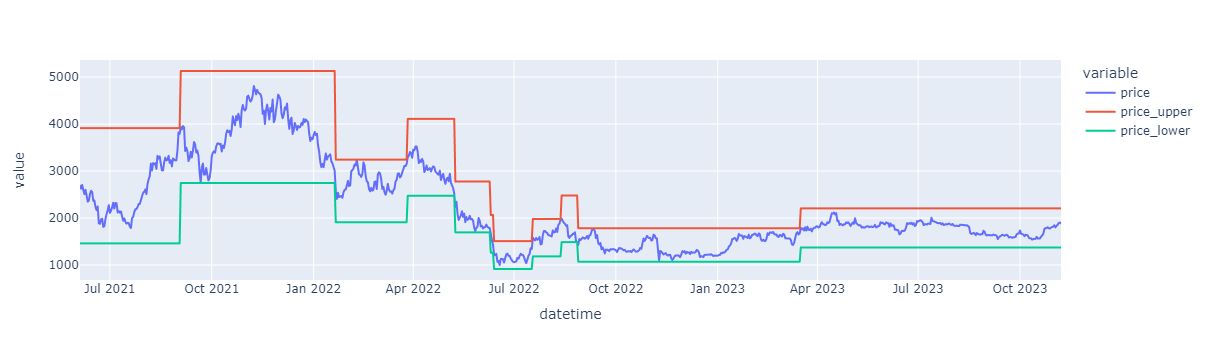

In [17]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

koef 1
Income: 0.7325080422688711


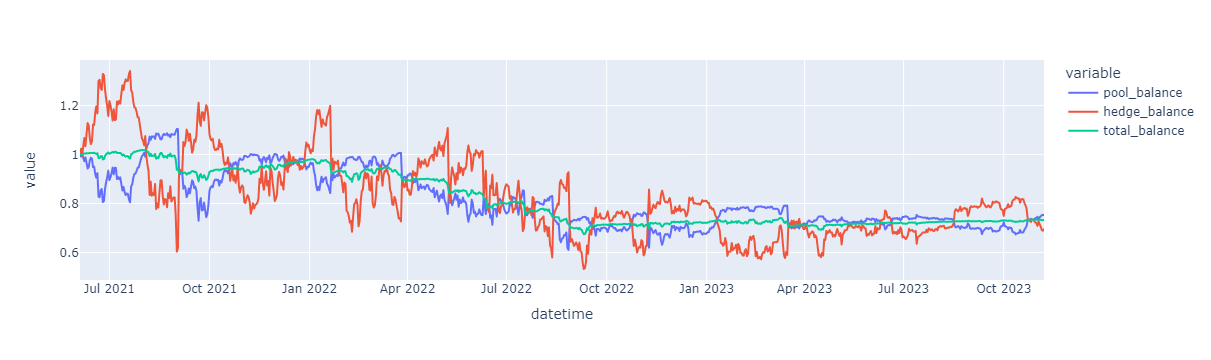

In [18]:
koef = 1
print("koef",koef)
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30)
data = strategy.run()
    
    
df = pd.DataFrame(data)
    
    
        # scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:", df['total_balance'].to_list()[-1])
    
px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

Казалось бы, значения уменьшились, но как показываю бектесты на других значения на самом деле стратегия достаточно хорошо работает. 

Вообще, на самом деле, если взять koef = 1, то по сути мы как бы "уберём" эту стратегию, а значит если мы будем проделывать бектесты, то хуже точно не станет. 

Давайте воспользумся $\Delta$ хэджированием, для этого при каждой ребалансеровке будем высчитывать некоторый коэффициент $H$, который будет показывать долю, которую мы хеджируем. Согласно [этой статье](https://lambert-guillaume.medium.com/how-to-deploy-delta-neutral-liquidity-in-uniswap-or-why-euler-finance-is-a-game-changer-for-lps-1d91efe1e8ac) формулы для рассчета будут следующие: $r = \sqrt{\frac{\text{PriceUpper}}{\text{PriceLower}}}$, $H = \frac{\sqrt{r} - 1}{r - 1}$

Хочу заметить, что на невалидных данных я беру некоторую заданную H, которую потом мы будем оптимизировать через тесты




Income: 0.7747093822700238


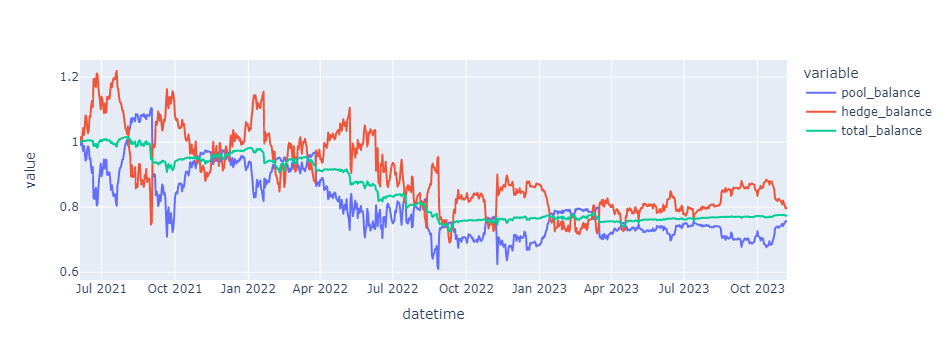

In [19]:
class Strategy:
    def __init__(self, 
                 states: pd.DataFrame,STD_COUNT,STD_TIMERANGE, START_EQUITY, H, bool
                ):
        self.params: dict = {
            'STD_COUNT': STD_COUNT,
            ''
            'START_EQUITY': START_EQUITY,
            'STD_TIMERANGE': STD_TIMERANGE,
            'H': H,
            'Bool': bool,# days
        }
        self._hedge: Hedge = Hedge()
        self._pool_position: UniswapV3Position = None
        self._states: pd.DataFrame = states
        self._data = []

    def update_fee(self, price: float, i: dict):  
        #10**(-18)*math.ceil(10**18 * 
        FeesTees = 0.0005
        liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
        liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
        
        if price < self._pool_position._price_lower:  
            deltaL = liquidityAmount0
        elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
            deltaL = min(liquidityAmount0, liquidityAmount1)  
        else:  
            deltaL = liquidityAmount1  
        self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))

    
    def calculate_std(self, timestamp: dt.datetime) -> float:
        return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std())

    def run(self):
        df_for_run = pd.DataFrame(self._states)
        for i, state in df_for_run.iterrows():
            if i < self.params['STD_TIMERANGE']:
                #print(f'Strategy | Skipping {state["datetime"]}')
                continue
            self._hedge.update_state(state['token0Price'], state['fundingRate'])
            if self._pool_position:
                self._pool_position.update_state(state['token0Price'])
                self.update_fee(self._pool_position._price_current, i)
                if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                    self.rebalance(state)
            else:
                self.rebalance(state)

            self._data.append([
                state['datetime'],
                state['token0Price'],
                self._pool_position.balance(),
                self._hedge.margin_balance(),
                self._pool_position.balance() + self._hedge.margin_balance(),
                self._pool_position._price_upper,
                self._pool_position._price_lower,
            ])

        return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])

    def rebalance(self, state):
        
        #print(f'Strategy | Start rebalancing at {state["datetime"]}')

        std = self.calculate_std(state['datetime'])
            
        if self._pool_position is not None:
            pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
            self._hedge.close_position()
            equity: float = pool_balance + self._hedge.margin_balance()
        else:
            equity: float = self.params['START_EQUITY']

        def is_valid_number(number):
            # Проверка на не NaN
            if np.isnan(number):
                return False
            # Проверка на не равно 0 и больше нуля
            if number > 0:
                return True
            return False
        
        #print("decim:",state['token0Price'] * (1 - std * self.params['STD_COUNT']))

        if(self.params['Bool']):
            if(is_valid_number(state['token0Price'] * (1 - std * self.params['STD_COUNT']))):
                r = math.sqrt((state['token0Price'] * (1 + std * self.params['STD_COUNT']))/(state['token0Price'] * (1 - std * self.params['STD_COUNT'])))
                H = (math.sqrt(r) - 1)/(r-1)
            else: H = self.params['H']
        else:
            H = self.params['H']
        
        # virtual witfhdraw and deposit for rebalancing capital
        self._hedge.withdraw(self._hedge.margin_balance())
        self._hedge.deposit(H * equity)

        self._pool_position = create_position_by_notional(
            (1-H)*equity,
            price_current=state['token0Price'],
            price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
            price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
        )
        self._hedge.open_position(
            size=-(self._pool_position.balance() / 2) / state['token0Price'],
            entry_price=state['token0Price'],
        )



# you can take filtered data
# filtered_data = all_data[all_data['datetime'] > dt.datetime(2021, 5, 5).date()]
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30, 1000000, 0.0001,True) #тут будет такая запись Strategy(all_data.sort_values('datetime').reset_index(), 3, 30, S, H,True)
data = strategy.run()


df = pd.DataFrame(data)


# scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:",df['total_balance'].to_list()[-1])

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])


Результаты выросли в примерно на 5% процентов, поэтому будем придерживаться модели $\Delta$-хеджирования 

Income: 0.7747093822700238


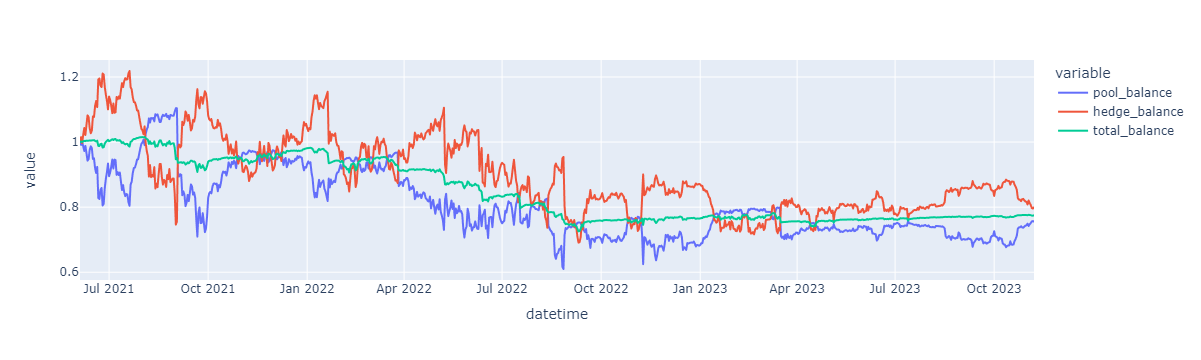

In [20]:
from datetime import datetime, timedelta
class Strategy:
    def __init__(self, 
                 states: pd.DataFrame,STD_COUNT,STD_TIMERANGE, START_EQUITY, koef, H, bool,day
                ):
        self.params: dict = {
            'STD_COUNT': STD_COUNT,
            ''
            'START_EQUITY': START_EQUITY,
            'STD_TIMERANGE': STD_TIMERANGE,
            'H': H,
            'Bool': bool,# days
            "Koef":koef,
            "Day":day
        }
        self._hedge: Hedge = Hedge()
        self._pool_position: UniswapV3Position = None
        self._states: pd.DataFrame = states
        self._data = []

    def update_fee(self, price: float, i: dict):  
        #10**(-18)*math.ceil(10**18 * 
        FeesTees = 0.0005
        liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
        liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
        
        if price < self._pool_position._price_lower:  
            deltaL = liquidityAmount0
        elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
            deltaL = min(liquidityAmount0, liquidityAmount1)  
        else:  
            deltaL = liquidityAmount1  
        self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))

    
    def calculate_std(self, timestamp: dt.datetime) -> float:
        lookback_period = self.params['Day']  # Ваш период в днях

        # Вычисляем начальную дату для фильтрации
        start_date = timestamp - timedelta(days=lookback_period)

        # Применяем фильтрацию к DataFrame self._states
        filtered_states = self._states[(self._states['datetime'] >= start_date) & (self._states['datetime'] <= timestamp)]
        
        # Рассчитываем стандартное отклонение для 'token0Price' в отфильтрованных данных
        std = abs(filtered_states['token0Price'].pct_change().std())
        return std




    def run(self):
        remember_price = None
        df_for_run = pd.DataFrame(self._states)
        for i, state in df_for_run.iterrows():
            if i < self.params['STD_TIMERANGE']:
            #print(f'Strategy | Skipping {state["datetime"]}')
                continue
    
            if not remember_price:
                remember_price = float(state['token0Price'])
                
                
            self._hedge.update_state(state['token0Price'], state['fundingRate'])
            if self._pool_position:
                self._pool_position.update_state(state['token0Price'])
                self.update_fee(self._pool_position._price_current, i)
                if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                    self.rebalance(state,True)
                    remember_price = None
                if not remember_price:
                    remember_price = float(state['token0Price'])
                if not (state['token0Price']*(1-self.params['Koef'])<= remember_price <= (1+self.params['Koef']) * state['token0Price']):
                    self.rebalance(state, False)
                    remember_price = None
            else:
                self.rebalance(state, True)
    
            self._data.append([
                state['datetime'],
                state['token0Price'],
                self._pool_position.balance(),
                self._hedge.margin_balance(),
                self._pool_position.balance() + self._hedge.margin_balance(),
                self._pool_position._price_upper,
                self._pool_position._price_lower,
            ])
    
        return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])
    
    def rebalance(self, state, bool):
            
            #print(f'Strategy | Start rebalancing at {state["datetime"]}')
    
        std = self.calculate_std(state['datetime'])
            #print(f'Strategy | Calculated std {std}')
            
        if self._pool_position is not None: 
            pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
            self._hedge.close_position()
            equity: float = pool_balance + self._hedge.margin_balance()
        else:
            equity: float = self.params['START_EQUITY']
    
        def is_valid_number(number):
            # Проверка на не NaN
            if np.isnan(number):
                return False
                # Проверка на не равно 0 и больше нуля
            if number > 0:
                return True
            return False
            
            #print("decim:",state['token0Price'] * (1 - std * self.params['STD_COUNT']))


        if(self.params['Bool']):
            if(is_valid_number(state['token0Price'] * (1 - std * self.params['STD_COUNT']))):
                r = math.sqrt((state['token0Price'] * (1 + std * self.params['STD_COUNT']))/(state['token0Price'] * (1 - std * self.params['STD_COUNT'])))
                H = (math.sqrt(r) - 1)/(r-1)
            else: H = self.params['H']
        else:
            H = self.params['H']
                #H =1/3
    
            
            # virtual witfhdraw and deposit for rebalancing capital
        self._hedge.withdraw(self._hedge.margin_balance())
        self._hedge.deposit(H * equity)
    
        if(bool):
            self._pool_position = create_position_by_notional(
                (1-H)*equity,
                price_current=state['token0Price'],
                price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
                price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
            )
        else:
            self._pool_position = create_position_by_notional(
                (1-H)*equity,
                price_current=state['token0Price'],
                price_upper = self._pool_position._price_upper,
                price_lower = self._pool_position._price_lower
            )
    
                
        self._hedge.open_position(
            size=-(self._pool_position.balance() / 2) / state['token0Price'],               
            entry_price=state['token0Price'],
        )



strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30, 1000000, 1,0.0001,True, 1000) #тут будет такая запись Strategy(all_data.sort_values('datetime').reset_index(), 3, 30, S, H,True)
data = strategy.run()


df = pd.DataFrame(data)


# scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:",df['total_balance'].to_list()[-1])

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])


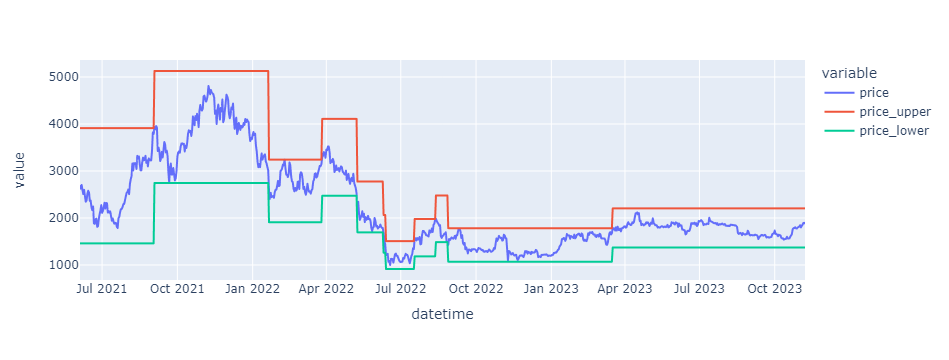

In [21]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

In [22]:
def what_last_total_balance(STD_COUNT,STD_TIMERANGE, START_EQUITY, Koef,H, day)->float:
    strategy = Strategy(all_data.sort_values('datetime').reset_index(), STD_COUNT, STD_TIMERANGE, START_EQUITY, Koef, H, True, day) #False
    data = strategy.run()
    df = pd.DataFrame(data)

    # scale all balances to first day
    df['total_balance'] = df['total_balance'] / df['total_balance'][0];
    return df['total_balance'].to_list()[-1];

#print(what_last_total_balance(5, 30, 100000, 1/3));

In [23]:
# Создайте массивы для каждого аргумента с использованием np.arange
arg1_values = np.arange(3,12)  # Например, для первого аргумента от 1 до 3
arg2_values = np.arange(5, 15, 2)  # Например, для второго аргумента от 1 до 15, я проводил много раз бектест и понял что это оптимальный промежуток, дальше 15 как правило ничего интересного нет 
arg3_values = np.arange(0.0, 0.99, 0.09)
arg4_values = [30,60,90, 180, 1000]
H_values = [0.00001,1/3,1/5,1]

max_value = -np.inf
max_indices = (0, 0, 0,0, 0)



# Вычислите значение функции для каждой комбинации аргументов
for arg1 in arg1_values:
    for arg2 in arg2_values:
        for arg3 in arg3_values:
            for arg4 in arg4_values:   
                for H_value in H_values:
                    result = what_last_total_balance(arg1, arg2, 100000, arg3, H_value,arg4)
                    if result > max_value:
                        max_value = result
                        max_indices = (arg1, arg2, arg3,arg4,H_value)

arg1 = max_indices[0]
arg2 = max_indices[1]
arg3 = max_indices[2]
arg4 = max_indices[3]
arg5 = max_indices[4]

print(f"Максимальное значение функции: {max_value}")
print(f"Индексы, где оно достигается: Std_Count={max_indices[0]}, Time_Range={max_indices[1]}, koef={max_indices[2]}, sigma_mode_day={max_indices[3]}, H={max_indices[4]}")

Максимальное значение функции: 1.1347897266169231
Индексы, где оно достигается: Std_Count=9, Time_Range=7, koef=0.63, sigma_mode_day=1000, H=1e-05


Income: 1.1347897266169231


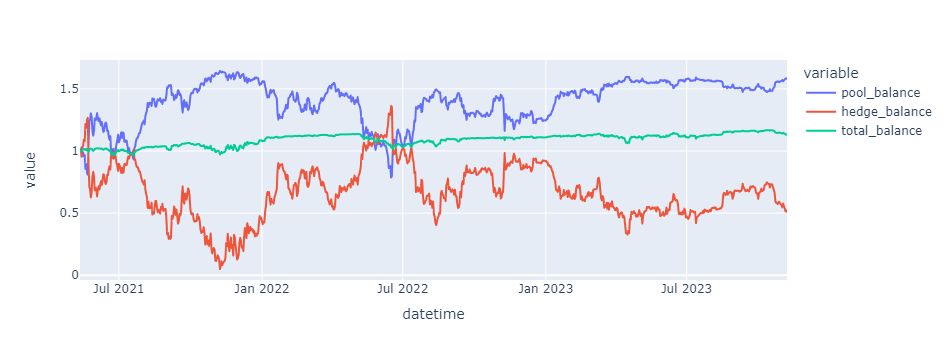

In [24]:
print("Income:",what_last_total_balance(arg1, arg2, 100000, arg3, arg5, arg4))
# you can take filtered data

strategy = Strategy(all_data.sort_values('datetime').reset_index(), arg1, arg2, 100000, arg3, arg5, True,arg4)
data = strategy.run()

df = pd.DataFrame(data)

# scale allalances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

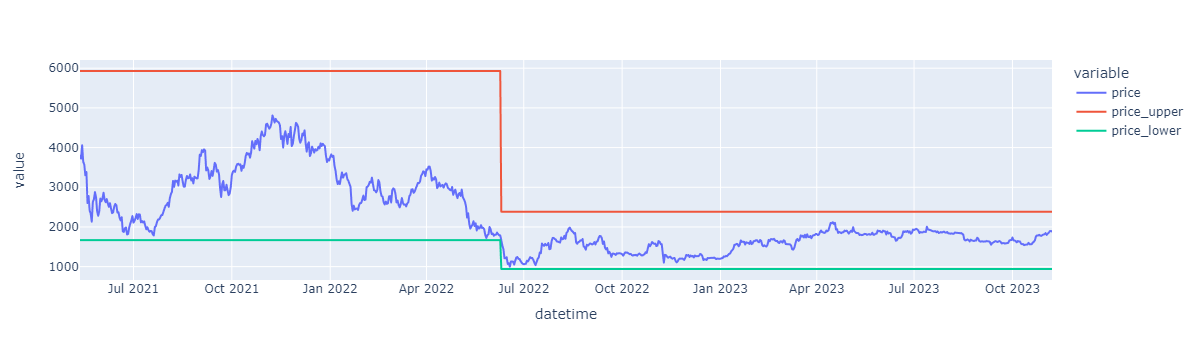

In [25]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

Чтож, из этого следует что на самом деле выгоднее всего использовать модель, предложенную на

Ну а теперь самое интересное, каким образом нам подбирать требуемые значения? Для этого предлагаю сгенерировать 100 траекторий, а затем оценить доходность на них, каким же образом мы будем оценивать доходности?

На самом деле вопрос абсолютно не тривиальный, так как положим у нас есть траектория которая даёт доходность 0.5, а другая 10, а другая стратегия даёт выгоду 1 и 1.2, как тогда определить наилучший?

Положим у нас есть доходности: $[a_1, ..., a_n]$, будто бы разумно сказать, что это некоторая выборка случайной величины $e^{\xi(\theta)}$, тогда очевидно нам хотелось бы чтобы наша $\xi(\theta)$ имела маленькую дисперсию и желательно положительное значение, я пока не изучал то, как задаются функции полезности для стратегий, поэтому строгого доказательства такой "оптимизации" не будет, поскольку она исходит из моих математических интуиций.

$\text{ }$

Так мы плавно переходим к Монте-Карло, посмотрев на модель геометрически-броуновского движения цены пониманием, что нам для начала высчитывать волатильность цены, для этого мы пробегаем по траектории цены и с окном в 30 дней, то есть мы смотрим на график цены, на -14 и +14 дней от него и из этого считаем волатильность, теперь давайте сгенерируем траектории, которые начинаются в $df['token0Price'][0]$ и будем задавать наши траектории как последовательную сумму случайных гауссовских величин  с $\mu = 0$ и $\sigma = df['volatility'][i]$


Собственно для оценки волатильности воспользуемся лог-ретёрнами, затем находим дисперцию, делим на количество записей и получаем $\sigma$ согласно модели геометрического-броуновского движения

$$S_t = S_0exp((\mu - \frac{{\sigma}^2}{2})t + {\sigma}{W_t})$$
$$S_{t+1} = S_0exp((\mu - \frac{{\sigma}^2}{2})(t+1) + {\sigma}{W_{t+1}})$$
$$log_{return} = ln(\frac{S_0exp((\mu - \frac{{\sigma}^2}{2})(t+1) + {\sigma}{W_{t+1}}}{S_0exp((\mu - \frac{{\sigma}^2}{2})t + {\sigma}{W_t}}) = (\mu - \frac{{\sigma}^2}{2}) + {\sigma}{W_{1}}$$
$$Var(log_{return}) = \sigma^2$$
$$E(log_{return}) = \mu - \frac{{\sigma}^2}{2}$$
$$\mu = E(log_{return}) + \frac{Var(log_{return})}{2}$$

$\text{}$

In [49]:
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

# Check if the DataFrame is empty
if not df.empty:
    # Calculate the variance of Log_Returns
    variance = df['Log_Returns'].var()
    matexp = df['Log_Returns'].mean()
    # Set the number of trajectories
    num_trajectories = 30

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, mu, sigma):
        time_points = np.arange(num_steps)
        random_steps = np.random.normal(0, 1, num_steps)
        random_steps[0] = 0
        trajectory = initial_price * np.exp((mu - sigma**2/2) * time_points + sigma * np.cumsum(random_steps))
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]  # Use .iloc[0] to access the first element
    
    sigma = np.sqrt(variance / len(df['Log_Returns']))  # Calculate sigma from variance
    mu = matexp + variance/2
    
    # Set the number of time steps
    num_steps = len(df)

    # Create an empty DataFrame for storing trajectories
    trajectories = pd.DataFrame()

    # Add the 'data' column to the 'trajectories'
    trajectories['datetime'] = df['datetime']

    # Create a 'Time' column with time points
    trajectories['Time'] = np.arange(num_steps)

    # Generate trajectories and add them to the DataFrame
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, mu, math.sqrt(sigma))
        column_name = f'Trajectory_{i + 1}'
        trajectories[column_name] = trajectory


else:
    print("DataFrame 'df' is empty.")


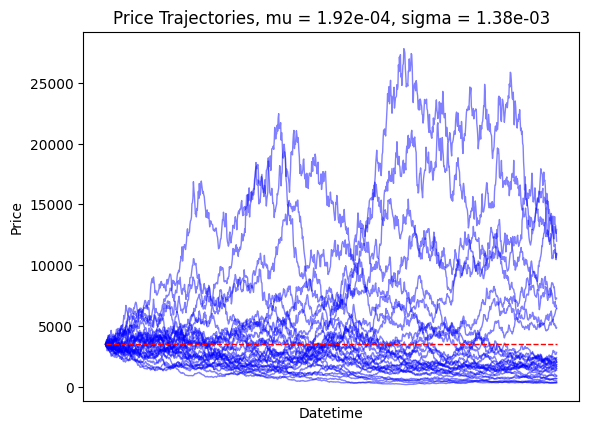

In [52]:
# Create a plot for each trajectory
for i in range(min(num_trajectories,30)):
    column_name = f'Trajectory_{i + 1}'
    plt.plot(trajectories['datetime'], trajectories[column_name], label=f'Trajectory {i + 1}', color='blue', linewidth=1, alpha=0.5)

constant_trajectory = [initial_price] * num_steps
plt.plot(trajectories['datetime'], constant_trajectory, label='Constant Trajectory', color='red', linestyle='--', linewidth=1)


# Set labels and title
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title(f'Price Trajectories, mu = {mu:.2e}, sigma = {sigma:.2e}')

plt.xticks([])
# Show a legend

# Display the plot
plt.show()


Окей, мы сгенерировали 30 траекторий, теперь напишем функцию для оценки доходности

In [28]:
def what_last_total_balance(all_data, STD_COUNT,STD_TIMERANGE, START_EQUITY, Koef,H, day, bool)->float:
    strategy = Strategy(all_data.sort_values('datetime').reset_index(), STD_COUNT, STD_TIMERANGE, START_EQUITY, Koef, H, bool, day) #False
    data = strategy.run()
    df = pd.DataFrame(data)

    # scale all balances to first day
    df['total_balance'] = df['total_balance'] / df['total_balance'][0];
    return df['total_balance'].to_list()[-1];

Теперь собственно проведем оптимизацию, будем оцевать вариацию ряда из логарифмов нашей итоговой доходности и надеятся на то, что будет стратегия с положительным мат. ожиданием

In [29]:
trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)

arg1_values = [0.1, 0.25, 0.5, 1, 3, 5, 8]  # Например, для первого аргумента от 1 до 3
arg2_values = np.arange(5, 13, 2)  # Например, для второго аргумента от 1 до 13, я проводил много раз бектест и понял что это оптимальный промежуток, дальше 15 как правило ничего интересного нет 
original_array = np.arange(0.05, 0.46, 0.1)
arg3_values = np.append(original_array, 1)
# arg3_values = (np.arange(0.01, 0.63, 0.09)).append([1])
arg4_values = [1000]
H_values = [0.00001,1/3,1/5,1]

min_value_var = np.inf
max_value_exp = -np.inf
min_indices_var = (0, 0, 0, 0, 0, 0,0)
max_indices_exp = (0, 0, 0, 0, 0, 0,0)

# Вычислите значение функции для каждой комбинации аргументов
for arg1 in arg1_values:
    for arg2 in arg2_values:
        for arg3 in arg3_values:
            for arg4 in arg4_values:
                for H_value in H_values:
                    result = np.array([])
                    for keys_name in trajectories_copy.keys():
                        all_data_copy = all_data.copy()  # Get the last value to append
                        all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
                        all_data_copy['token0Price'][0] = all_data['token0Price'][0]
                        result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, H_value, arg4, True))
                    result_var = (np.log(result)).var()
                    result_mean = np.log(result).mean()
                    if result_var < min_value_var:
                        min_value_var = result_var
                        min_indices_var = (arg1, arg2, arg3,arg4, H_value, math.e**result_mean,result_var)
    
                    if result_mean > max_value_exp:
                        max_value_exp = result_mean
                        max_indices_exp = (arg1, arg2, arg3,arg4, H_value, math.e**result_mean,result_var)


print("Если мы максимизируем по ожиданию:")
print(f"Вариация:{max_indices_exp[6]}, Мат.Ожидание:{max_indices_exp[5]}\nИндексы, где оно достигается: Std_Count={max_indices_exp[0]}, Time_Range={max_indices_exp[1]}, H = {max_indices_exp[4]},koef={max_indices_exp[2]}, sigma_mode_day={max_indices_exp[3]}\n")


print("Если мы минимизируем по вариации:")
print(f"Вариация:{min_indices_var[6]}, Мат.Ожидание:{min_indices_var[5]}\nИндексы, где оно достигается: Std_Count={min_indices_var[0]}, Time_Range={min_indices_var[1]}, H = {min_indices_var[4]}, koef={min_indices_var[2]}, sigma_mode_day={min_indices_var[3]}")

Если мы максимизируем по ожиданию:
Вариация:0.021304581071891766, Мат.Ожидание:0.721777210364004
Индексы, где оно достигается: Std_Count=8, Time_Range=7, H = 1e-05,koef=1.0, sigma_mode_day=1000

Если мы минимизируем по вариации:
Вариация:0.014126302406034897, Мат.Ожидание:0.5413113168834935
Индексы, где оно достигается: Std_Count=5, Time_Range=5, H = 1e-05, koef=0.05, sigma_mode_day=1000


$\text{}$

Теперь посмотрим как эти стратегии себя ведут и сравним их с изначальной. Сейчас я буду создавать 1000 траекторий, сначала это будет обычная модель с теме же значениями на которых выборка тренировалась, затем 3 предложенные в домашней работе стратегии: бычий тренд, медвежий и флэт. В качестве иллюстраций будет приводить распределение доходностей, которые получил от стратегии на этих 1000 траекториях.

Сначала будет стратегия минимизации вариации, затем максимизации мат.ожидания, а в конце изначальная стратегия, которая была предложена на семинаре (как я и обещал в одной из ячеек выше при помощи параметров можно было задать изначальную стратегию.

In [59]:
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

# Check if the DataFrame is empty
if not df.empty:
    # Calculate the variance of Log_Returns
    variance = df['Log_Returns'].var()
    matexp = df['Log_Returns'].mean()
    # Set the number of trajectories
    num_trajectories = 1000

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, mu, sigma):
        time_points = np.arange(num_steps)
        random_steps = np.random.normal(0, 1, num_steps)
        random_steps[0] = 0
        trajectory = initial_price * np.exp((mu - sigma**2/2) * time_points + sigma * np.cumsum(random_steps))
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]  # Use .iloc[0] to access the first element
    
    sigma = np.sqrt(variance / len(df['Log_Returns']))  # Calculate sigma from variance
    mu = matexp + variance/2
    #pritn(mu)
    
    # Set the number of time steps
    num_steps = len(df)

    # Create an empty DataFrame for storing trajectories
    trajectories = pd.DataFrame()

    # Add the 'data' column to the 'trajectories'
    trajectories['datetime'] = df['datetime']

    # Create a 'Time' column with time points
    trajectories['Time'] = np.arange(num_steps)

    # Generate trajectories and add them to the DataFrame
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, mu, math.sqrt(sigma))
        column_name = f'Trajectory_{i + 1}'
        trajectories[column_name] = trajectory


else:
    print("DataFrame 'df' is empty.")


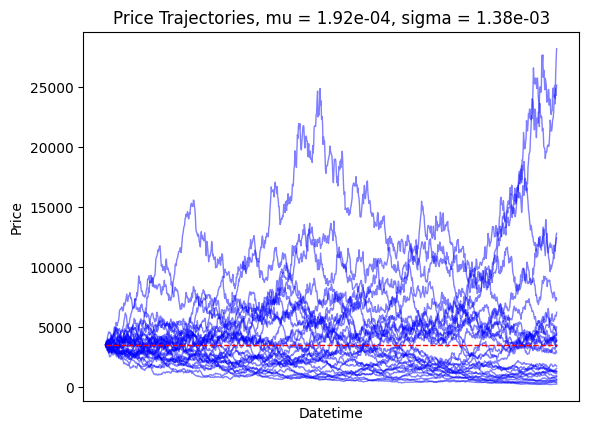

In [60]:
# Create a plot for each trajectory
for i in range(min(num_trajectories,30)):
    column_name = f'Trajectory_{i + 1}'
    plt.plot(trajectories['datetime'], trajectories[column_name], label=f'Trajectory {i + 1}', color='blue', linewidth=1, alpha=0.5)

constant_trajectory = [initial_price] * num_steps
plt.plot(trajectories['datetime'], constant_trajectory, label='Constant Trajectory', color='red', linestyle='--', linewidth=1)


# Set labels and title
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title(f'Price Trajectories, mu = {mu:.2e}, sigma = {sigma:.2e}')

plt.xticks([])
# Show a legend

# Display the plot
plt.show()


$\text{}$

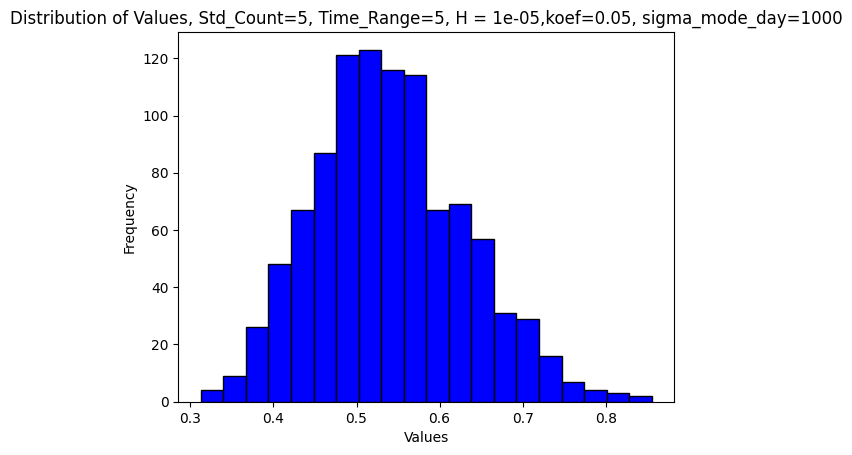

In [61]:
arg1 = min_indices_var[0]
arg2 = min_indices_var[1]
arg3 = min_indices_var[2]
arg4 = min_indices_var[3]
arg5 = min_indices_var[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

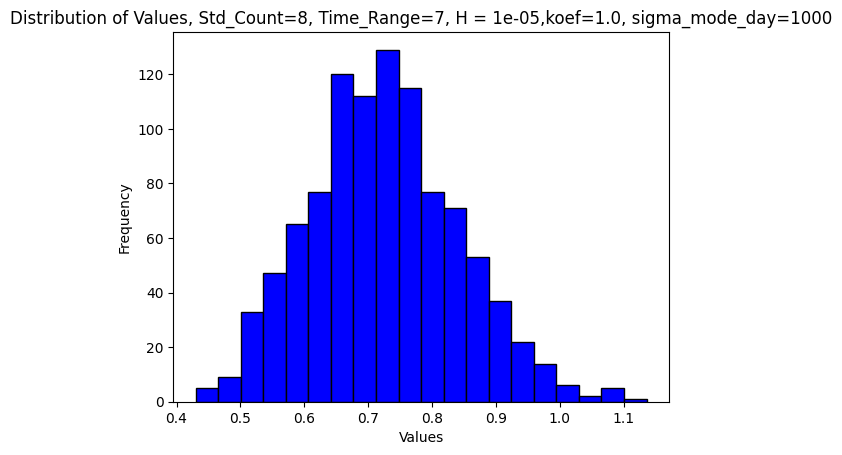

In [62]:
arg1 = max_indices_exp[0]
arg2 = max_indices_exp[1]
arg3 = max_indices_exp[2]
arg4 = max_indices_exp[3]
arg5 = max_indices_exp[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

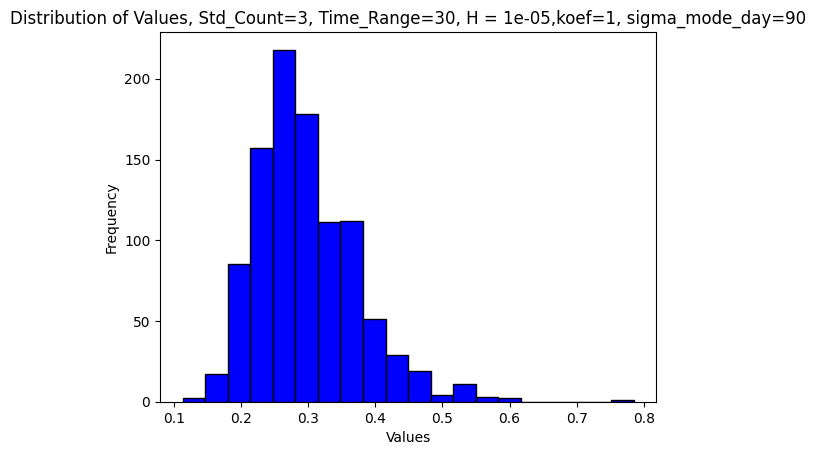

In [63]:
arg1 = 3
arg2 = 30
arg3 = 1
arg4 = 90
H = 1/3

trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, H, arg4, False))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

In [64]:
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

# Check if the DataFrame is empty
if not df.empty:
    # Calculate the variance of Log_Returns
    variance = df['Log_Returns'].var()

    # Set the number of trajectories
    num_trajectories = 1000

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, mu, sigma):
        time_points = np.arange(num_steps)
        random_steps = np.random.normal(0, 1, num_steps)
        random_steps[0] = 0
        trajectory = initial_price * np.exp((mu - sigma**2/2) * time_points + sigma * np.cumsum(random_steps))
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]  # Use .iloc[0] to access the first element
    mu = 0  # Set mu
    sigma = np.sqrt(variance / len(df['Log_Returns']))  # Calculate sigma from variance

    # Set the number of time steps
    num_steps = len(df)

    # Create an empty DataFrame for storing trajectories
    trajectories = pd.DataFrame()

    # Add the 'data' column to the 'trajectories'
    trajectories['datetime'] = df['datetime']

    # Create a 'Time' column with time points
    trajectories['Time'] = np.arange(num_steps)

    # Generate trajectories and add them to the DataFrame
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, mu, math.sqrt(sigma)/10**2)
        column_name = f'Trajectory_{i + 1}'
        trajectories[column_name] = trajectory


else:
    print("DataFrame 'df' is empty.")


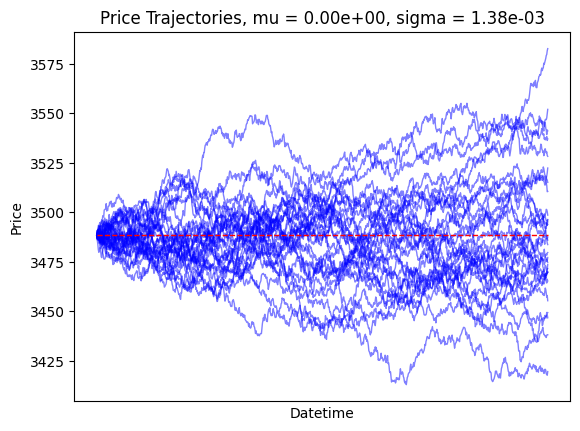

In [65]:
# Create a plot for each trajectory
for i in range(min(num_trajectories,30)):
    column_name = f'Trajectory_{i + 1}'
    plt.plot(trajectories['datetime'], trajectories[column_name], label=f'Trajectory {i + 1}', color='blue', linewidth=1, alpha=0.5)

constant_trajectory = [initial_price] * num_steps
plt.plot(trajectories['datetime'], constant_trajectory, label='Constant Trajectory', color='red', linestyle='--', linewidth=1)


# Set labels and title
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title(f'Price Trajectories, mu = {mu:.2e}, sigma = {sigma:.2e}')

plt.xticks([])
# Show a legend

# Display the plot
plt.show()


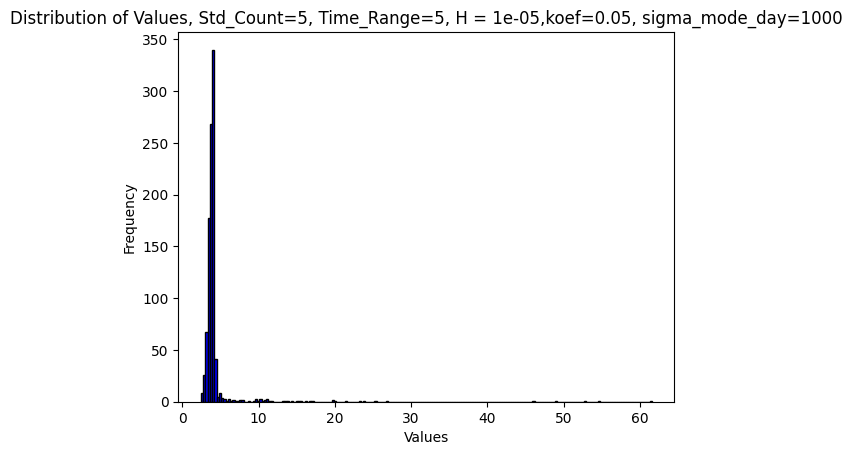

In [66]:
arg1 = min_indices_var[0]
arg2 = min_indices_var[1]
arg3 = min_indices_var[2]
arg4 = min_indices_var[3]
arg5 = min_indices_var[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=200, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

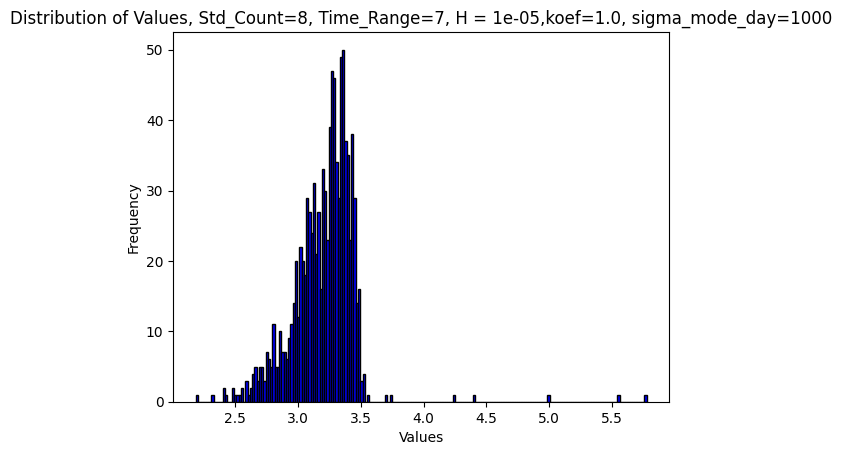

In [67]:
arg1 = max_indices_exp[0]
arg2 = max_indices_exp[1]
arg3 = max_indices_exp[2]
arg4 = max_indices_exp[3]
arg5 = max_indices_exp[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=200, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

In [68]:
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

# Check if the DataFrame is empty
if not df.empty:
    # Calculate the variance of Log_Returns
    variance = df['Log_Returns'].var()

    # Set the number of trajectories
    num_trajectories = 1000

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, mu, sigma):
        time_points = np.arange(num_steps)
        random_steps = np.random.normal(0, 1, num_steps)
        random_steps[0] = 0
        trajectory = initial_price * np.exp((mu - sigma**2/2) * time_points + sigma * np.cumsum(random_steps))
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]
    mu = -1/10**3  # Set mu
    sigma = np.sqrt(variance / len(df['Log_Returns']))  # Calculate sigma from variance

    # Set the number of time steps
    num_steps = len(df)

    # Create an empty DataFrame for storing trajectories
    trajectories = pd.DataFrame()

    # Add the 'data' column to the 'trajectories'
    trajectories['datetime'] = df['datetime']

    # Create a 'Time' column with time points
    trajectories['Time'] = np.arange(num_steps)

    # Generate trajectories and add them to the DataFrame
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, mu, math.sqrt(sigma))
        column_name = f'Trajectory_{i + 1}'
        trajectories[column_name] = trajectory

    # Display the generated trajectories with the 'data' column
    #print(trajectories)

else:
    print("DataFrame 'df' is empty.")


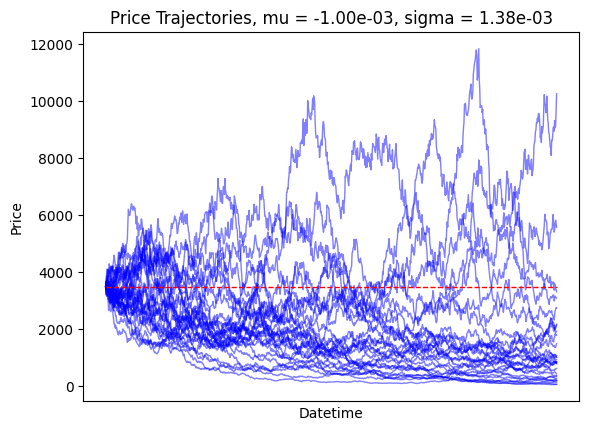

In [69]:
# Create a plot for each trajectory
for i in range(min(num_trajectories,30)):
    column_name = f'Trajectory_{i + 1}'
    plt.plot(trajectories['datetime'], trajectories[column_name], label=f'Trajectory {i + 1}', color='blue', linewidth=1, alpha=0.5)

constant_trajectory = [initial_price] * num_steps
plt.plot(trajectories['datetime'], constant_trajectory, label='Constant Trajectory', color='red', linestyle='--', linewidth=1)


# Set labels and title
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title(f'Price Trajectories, mu = {mu:.2e}, sigma = {sigma:.2e}')

plt.xticks([])
# Show a legend

# Display the plot
plt.show()


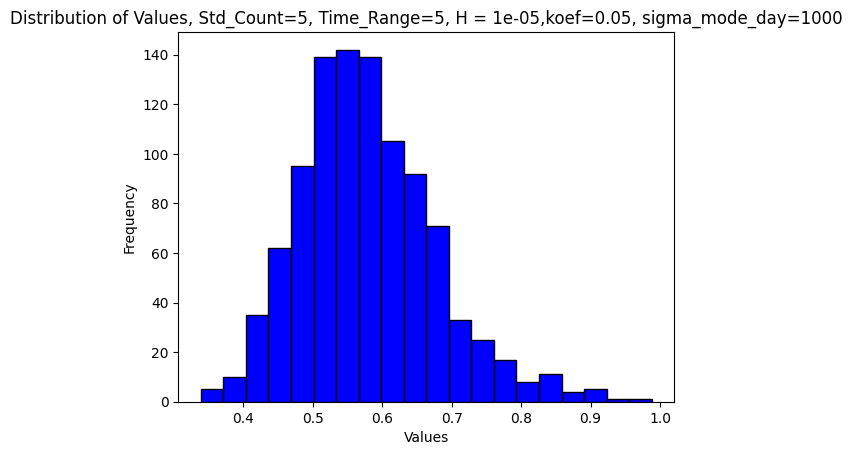

In [70]:
arg1 = min_indices_var[0]
arg2 = min_indices_var[1]
arg3 = min_indices_var[2]
arg4 = min_indices_var[3]
arg5 = min_indices_var[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

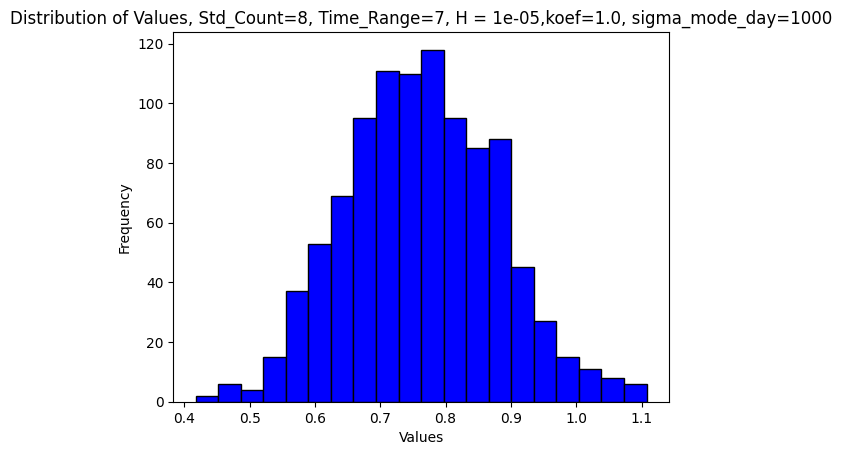

In [71]:
arg1 = max_indices_exp[0]
arg2 = max_indices_exp[1]
arg3 = max_indices_exp[2]
arg4 = max_indices_exp[3]
arg5 = max_indices_exp[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')
# Show the plot
plt.show()

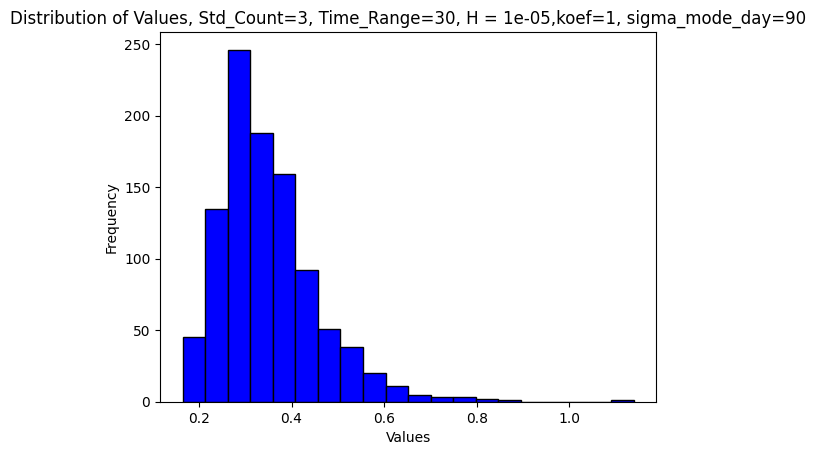

In [72]:
arg1 = 3
arg2 = 30
arg3 = 1
arg4 = 90
H = 1/3

trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, H, arg4, False))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()
# Now, the 'token0Price' column in all_data contains the chosen trajectory

In [73]:
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

# Check if the DataFrame is empty
if not df.empty:
    # Calculate the variance of Log_Returns
    variance = df['Log_Returns'].var()

    # Set the number of trajectories
    num_trajectories = 1000

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, mu, sigma):
        time_points = np.arange(num_steps)
        random_steps = np.random.normal(0, 1, num_steps)
        random_steps[0] = 0
        trajectory = initial_price * np.exp((mu - sigma**2/2) * time_points + sigma * np.cumsum(random_steps))
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]  # Use .iloc[0] to access the first element
    mu = 1/10**3  # Set mu
    sigma = np.sqrt(variance / len(df['Log_Returns']))  # Calculate sigma from variance

    # Set the number of time steps
    num_steps = len(df)

    # Create an empty DataFrame for storing trajectories
    trajectories = pd.DataFrame()

    # Add the 'data' column to the 'trajectories'
    trajectories['datetime'] = df['datetime']

    # Create a 'Time' column with time points
    trajectories['Time'] = np.arange(num_steps)

    # Generate trajectories and add them to the DataFrame
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, mu, math.sqrt(sigma))
        column_name = f'Trajectory_{i + 1}'
        trajectories[column_name] = trajectory


else:
    print("DataFrame 'df' is empty.")


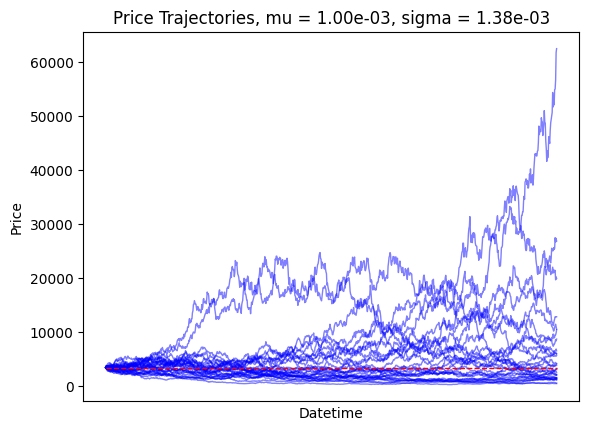

In [74]:
# Create a plot for each trajectory
for i in range(min(num_trajectories,30)):
    column_name = f'Trajectory_{i + 1}'
    plt.plot(trajectories['datetime'], trajectories[column_name], label=f'Trajectory {i + 1}', color='blue', linewidth=1, alpha=0.5)

constant_trajectory = [initial_price] * num_steps
plt.plot(trajectories['datetime'], constant_trajectory, label='Constant Trajectory', color='red', linestyle='--', linewidth=1)


# Set labels and title
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title(f'Price Trajectories, mu = {mu:.2e}, sigma = {sigma:.2e}')

plt.xticks([])
# Show a legend

# Display the plot
plt.show()


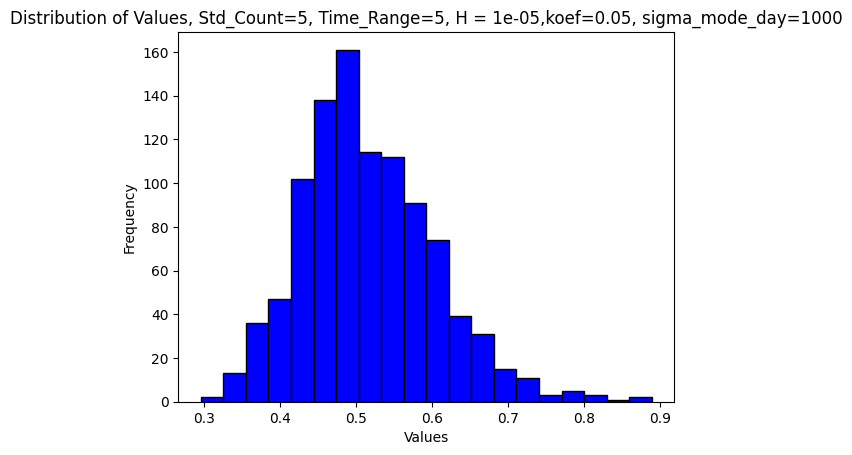

In [75]:
arg1 = min_indices_var[0]
arg2 = min_indices_var[1]
arg3 = min_indices_var[2]
arg4 = min_indices_var[3]
arg5 = min_indices_var[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

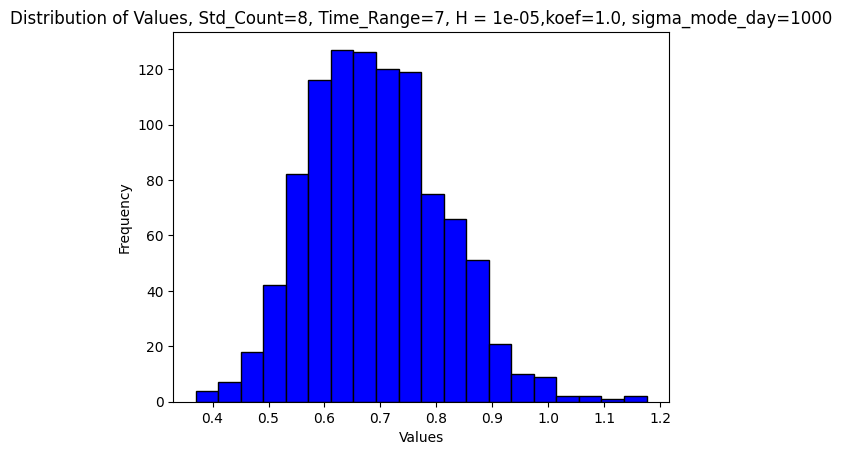

In [76]:
arg1 = max_indices_exp[0]
arg2 = max_indices_exp[1]
arg3 = max_indices_exp[2]
arg4 = max_indices_exp[3]
arg5 = max_indices_exp[4]



trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, arg5, arg4, True))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

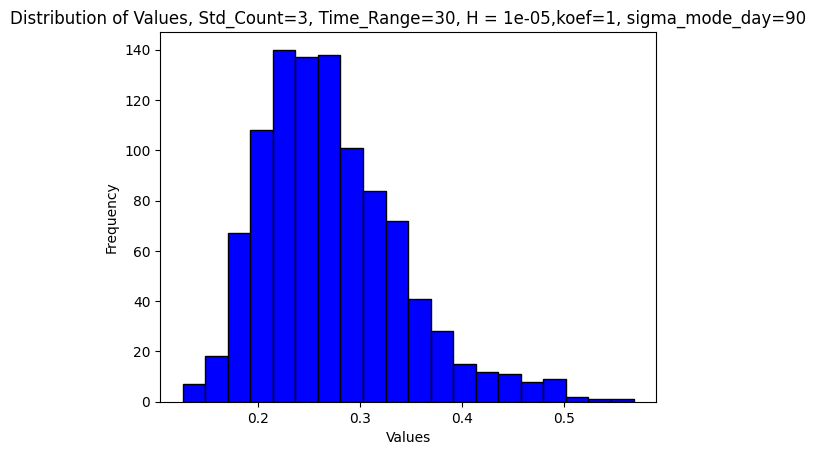

In [77]:
arg1 = 3
arg2 = 30
arg3 = 1
arg4 = 90
H = 1/3

trajectories_copy = trajectories.copy()

trajectories_copy = trajectories_copy.drop('datetime', axis=1)
trajectories_copy = trajectories_copy.drop('Time', axis=1)
#print(trajectories_copy)

result =np.array([])
for keys_name in trajectories_copy.keys():
    # print(all_data)
    all_data_copy = all_data.copy()  # Get the last value to append
    all_data_copy['token0Price'] = trajectories_copy[keys_name] #initial_price
    all_data_copy['token0Price'][0] = all_data['token0Price'][0]
    result = np.append(result, what_last_total_balance(all_data_copy, arg1, arg2, 100000, arg3, H, arg4, False))



plt.hist(result, bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of Values, Std_Count={arg1}, Time_Range={arg2}, H = {arg5},koef={arg3}, sigma_mode_day={arg4}')

# Show the plot
plt.show()

Чтож, можно подытожить, что наша стратегия скорее всего на реальных данных будет убыточная, однако мы вдвое улучшили доходность стратегии, которая изначально предложена на семинаре 